<a href="https://www.kaggle.com/code/dalloliogm/smiles-rdkit-autogluon-ftw?scriptVersionId=246205088" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## 

## Autogluon Notebook

This is a modified version of this amazing notebook: [smiles-rdkit-lgbm-ftw](https://www.kaggle.com/code/richolson/smiles-rdkit-lgbm-ftw). Instead of using LGBM, we use Autogluon, an auto-ml framework.

# SMILES->RDKIT->LGBM->FTW  🧪⚡🚀

**SMILES** *(Simplified Molecular Input Line Entry System)*  
**RDKIT** *(Open-source cheminformatics toolkit)*   
**AutoGLuon** *AUtomated Machine Learning*
**FTW** *(For The Win!)*  

## 1. Use RDKit to calculate *chemical descriptors* from our SMILES molecule data
- **Structural Counts:** Ring counts, rotatable bonds, molecular weight
- **Calculated Properties:** LogP (oiliness), TPSA (surface area), qed (drug-likeness), complexity/shape stuff
- We infer these for both **train** and **test** data
- **We are using RDKit to do feature engineering**

## 2. Train models using those features to predict our *targets*:
- **Tg** - Glass transition temperature (°C)
- **FFV** - Fractional free volume
- **Tc** - Thermal conductivity (W/m·K)
- **Density** - Polymer density (g/cm³)
- **Rg** - Radius of gyration (Å)

## We train unique Autogluon models for each target!
- Actually 5 models per target using CV / averaging predictions (**25 models total!**)
- **RDKit is doing the heavy-lifting here** - we just train a model to figure out how to translate the data to our targets...

*Friendly Reminder:* If re-using large parts of this work in a public notebook - **please credit where you found the code**

# Install RDKit and Autogluon
* https://www.kaggle.com/datasets/richolson/rdkit-install-whl

In [1]:
# Install Autogluon for offline use
!pip install -q autogluon --no-index --find-links=file:///kaggle/input/autogluon-install-notebook

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
textblob 0.19.0 requires nltk>=3.9, but you have nltk 3.8.1 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-

In [2]:
# install RDKit for offline use
!pip install /kaggle/input/rdkit-install-whl/rdkit_wheel/rdkit_pypi-2022.9.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Processing /kaggle/input/rdkit-install-whl/rdkit_wheel/rdkit_pypi-2022.9.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [3]:
import os
def is_interactive_session():
    return os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'

is_interactive_session()

config = {
    "autogluon_time": 60*60*0.2,
    "autogluon_presets": "best_quality",
    #"reduce_features": 0, # Set to >0 to use only the first n features
    "tail_rows": 0 # Set to >0 to use only the last n rows in the file
    
}

if is_interactive_session():
    print("Interactive session")
    config["autogluon_time"] = 100
    #config["reduce_features"] = 200
    config["autogluon_presets"] = "medium_quality"
    config["tail_rows"] = 2000
    print(config)
else:
    print("running as job")
    print(config)

running as job
{'autogluon_time': 720.0, 'autogluon_presets': 'best_quality', 'tail_rows': 0}


In [4]:
import pandas as pd
import autogluon as ag
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Simple SMILES / RDKit Demo
* So you can see how this works...

In [5]:
molecules = [
    ('CCO', 'Ethanol - simple alcohol'),
    ('CCCCCCCC', 'Octane - long chain'),
    ('c1ccccc1', 'Benzene - aromatic ring'),
    ('COO', 'CO2'),
    ("O", "Water")

]

for smiles, description in molecules:
    mol = Chem.MolFromSmiles(smiles)
    
    print(f"\n{description}")
    print(f"SMILES: {smiles}")
    print(f"  Molecular Weight: {Descriptors.MolWt(mol):.1f}")
    print(f"  LogP (oiliness): {Descriptors.MolLogP(mol):.2f}")
    print(f"  Rotatable Bonds: {Descriptors.NumRotatableBonds(mol)}")
    print(f"  Aromatic Rings: {Descriptors.NumAromaticRings(mol)}")
    print(f"  Complexity (BertzCT): {Descriptors.BertzCT(mol):.0f}")


Ethanol - simple alcohol
SMILES: CCO
  Molecular Weight: 46.1
  LogP (oiliness): -0.00
  Rotatable Bonds: 0
  Aromatic Rings: 0
  Complexity (BertzCT): 3

Octane - long chain
SMILES: CCCCCCCC
  Molecular Weight: 114.2
  LogP (oiliness): 3.37
  Rotatable Bonds: 5
  Aromatic Rings: 0
  Complexity (BertzCT): 25

Benzene - aromatic ring
SMILES: c1ccccc1
  Molecular Weight: 78.1
  LogP (oiliness): 1.69
  Rotatable Bonds: 0
  Aromatic Rings: 1
  Complexity (BertzCT): 72

CO2
SMILES: COO
  Molecular Weight: 48.0
  LogP (oiliness): 0.11
  Rotatable Bonds: 0
  Aromatic Rings: 0
  Complexity (BertzCT): 3

Water
SMILES: O
  Molecular Weight: 18.0
  LogP (oiliness): -0.82
  Rotatable Bonds: 0
  Aromatic Rings: 0
  Complexity (BertzCT): 0


# Load Data

In [6]:
# Load data
train_df = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/test.csv')

In [7]:
train_df.head()

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


# Define molecular descriptions to be generated by RDKit
* These are properties that RDKit can determine based on SMILES data
* Auto-discovers 400 descriptors defined by RDKit
* Only uses a subset of 192 AUTOCORR2D descriptors (as defined by max_autocorr) 
* We run this function on **train and test** data
* We develop models to take this information and predict our actual targets  ('Tg', 'FFV', 'Tc', 'Density', 'Rg')

In [8]:
from rdkit.Chem import Descriptors
from rdkit import Chem
import numpy as np

def get_molecular_descriptors(max_autocorr=10):
    """Get molecular descriptors - either hardcoded list or auto-discovered"""

    descriptor_list_all = []
    test_mol = Chem.MolFromSmiles('CCO')

    # Collect all valid descriptors first
    for name in dir(Descriptors):
        if not name.startswith('_'):
            try:
                func = getattr(Descriptors, name)
                if callable(func):
                    result = func(test_mol)
                    if isinstance(result, (int, float)) and not np.isnan(result):
                        descriptor_list_all.append((name, func))
            except:
                pass

    print(f"🔍 Total discovered descriptors before filtering: {len(descriptor_list_all)}")

    # Sort AUTOCORR2D descriptors by their numeric suffix
    autocorr_descriptors = [
        (name, func)
        for name, func in descriptor_list_all
        if name.startswith('AUTOCORR2D_')
    ]
    autocorr_descriptors.sort(key=lambda x: int(x[0].split('_')[-1]))

    # Select only the lowest-numbered ones
    limited_autocorr = autocorr_descriptors[:max_autocorr]

    # Include all other descriptors
    other_descriptors = [
        (name, func)
        for name, func in descriptor_list_all
        if not name.startswith('AUTOCORR2D_')
    ]

    # Final descriptor list
    descriptor_list = limited_autocorr + other_descriptors

    print(f"✅ Auto-discovered {len(descriptor_list)} descriptors (limited to {max_autocorr} AUTOCORR2D):")
    names = [name for name, _ in descriptor_list]
    print("  " + ", ".join(names))

    feature_names = [name for name, _ in descriptor_list]
    return descriptor_list, feature_names

molecular_descriptors =  get_molecular_descriptors(max_autocorr=10) 

🔍 Total discovered descriptors before filtering: 400
✅ Auto-discovered 218 descriptors (limited to 10 AUTOCORR2D):
  AUTOCORR2D_1, AUTOCORR2D_2, AUTOCORR2D_3, AUTOCORR2D_4, AUTOCORR2D_5, AUTOCORR2D_6, AUTOCORR2D_7, AUTOCORR2D_8, AUTOCORR2D_9, AUTOCORR2D_10, BCUT2D_CHGHI, BCUT2D_CHGLO, BCUT2D_LOGPHI, BCUT2D_LOGPLOW, BCUT2D_MRHI, BCUT2D_MRLOW, BCUT2D_MWHI, BCUT2D_MWLOW, BalabanJ, BertzCT, Chi0, Chi0n, Chi0v, Chi1, Chi1n, Chi1v, Chi2n, Chi2v, Chi3n, Chi3v, Chi4n, Chi4v, EState_VSA1, EState_VSA10, EState_VSA11, EState_VSA2, EState_VSA3, EState_VSA4, EState_VSA5, EState_VSA6, EState_VSA7, EState_VSA8, EState_VSA9, ExactMolWt, FpDensityMorgan1, FpDensityMorgan2, FpDensityMorgan3, FractionCSP3, HallKierAlpha, HeavyAtomCount, HeavyAtomMolWt, Ipc, Kappa1, Kappa2, Kappa3, LabuteASA, MaxAbsEStateIndex, MaxAbsPartialCharge, MaxEStateIndex, MaxPartialCharge, MinAbsEStateIndex, MinAbsPartialCharge, MinEStateIndex, MinPartialCharge, MolLogP, MolMR, MolWt, NHOHCount, NOCount, NumAliphaticCarbocycles, 

# Run RDKit on SMILES Train data
* Predicts molecular descriptors we previously defined
* This is time intensive - so we do it once here instead of in training loop
* This function is also used to process Test data later

In [9]:
def smiles_to_features(smiles_list, descriptor_functions):
   """Convert SMILES strings to raw feature matrix"""
   
   features = []
   total = len(smiles_list)
   
   print(f"Processing {total} SMILES...", end="", flush=True)
   
   for i, smiles in enumerate(smiles_list):
       # Progress indicator every 1000 molecules or at milestones
       if i > 0 and (i % 1000 == 0 or i == total - 1):
           print(f" {i+1}/{total}", end="", flush=True)
       
       mol_features = []
       try:
           mol = Chem.MolFromSmiles(smiles)
           if mol is None:
               # Invalid SMILES - fill with NaN
               mol_features = [np.nan] * len(descriptor_functions)
           else:
               # Calculate each descriptor
               for name, func in descriptor_functions:
                   try:
                       value = func(mol)
                       # Handle problematic values
                       if np.isinf(value) or abs(value) > 1e10:
                           value = np.nan
                       mol_features.append(value)
                   except:
                       # Descriptor calculation failed
                       mol_features.append(np.nan)
       except:
           # Complete failure - fill entire row with NaN
           mol_features = [np.nan] * len(descriptor_functions)
       
       features.append(mol_features)
   
   print(" ✅", flush=True)
   return np.array(features, dtype=float)

descriptor_functions, feature_names = molecular_descriptors
X_raw = smiles_to_features(train_df['SMILES'].values, descriptor_functions)    

Processing 7973 SMILES... 1001/7973 2001/7973 3001/7973 4001/7973 5001/7973 6001/7973 7001/7973 7973/7973 ✅


# Clean Train Data
* Just replaces any NaNs with Median for the column
* This function is also used to process Test data later

In [10]:
def clean_features(X):
   """Handle NaN/inf values and impute missing data"""
   X[np.isinf(X)] = np.nan
   
   # Count and report missing values
   missing = np.isnan(X).sum()
   print(f"🧹 Cleaned {missing:,} missing values ({missing/X.size*100:.1f}%)")
   
   # Median imputation
   for i in range(X.shape[1]):
       col = X[:, i]
       if np.isnan(col).any():
           X[np.isnan(col), i] = np.nanmedian(col) if not np.isnan(np.nanmedian(col)) else 0
   
   return X

train_features = pd.DataFrame(clean_features(X_raw))

🧹 Cleaned 96,915 missing values (5.6%)


In [11]:
train_features.columns = feature_names
train_features.head()

,AUTOCORR2D_1,AUTOCORR2D_2,AUTOCORR2D_3,AUTOCORR2D_4,AUTOCORR2D_5,AUTOCORR2D_6,AUTOCORR2D_7,AUTOCORR2D_8,AUTOCORR2D_9,AUTOCORR2D_10,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,2.944,3.126,3.178,3.120,2.890,2.539,2.428,2.335,2.842,2.978,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.500278
1,3.919,4.229,4.352,4.361,4.374,4.258,4.174,4.248,3.902,4.205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.125364
2,4.631,4.955,5.035,4.908,4.892,4.814,4.697,4.754,4.393,4.724,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092387
3,3.878,4.244,4.357,4.435,4.670,4.793,4.785,4.631,3.861,4.220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209590
4,4.429,4.697,4.734,4.718,4.653,4.617,4.660,4.629,4.227,4.468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.014164


 # Function to Train AUTOGLUON
 for a given target
 * Runs RDKit feature generation on SMILES data
 * Creates / trains a model for a specific target ('Tg', 'FFV', 'Tc', 'Density', 'Rg')
 * Uses 5x cross-validation to utilize all training data (5 models per feature)

In [12]:
train_targets = train_df[['Tg', 'FFV', 'Tc', 'Density', 'Rg']]  # Y targets


In [13]:
from autogluon.tabular import TabularPredictor

def train_target_property_autogluon(X, train_df, target_name, time_limit=300, presets="best_quality", hyperparameters={}):
    """
    Trains an AutoGluon model to predict a single target property.

    Returns:
        predictor: Trained TabularPredictor.
        scaler: None (for compatibility with legacy unpacking).
        feature_names: List of feature names used.
        best_model_score: MAE on internal validation.
        leaderboard_df: AutoGluon leaderboard DataFrame.
    """
    # Filter samples with target value
    mask = train_df[target_name].notna()
    X_target = X.loc[mask].copy()
    y_target = train_df.loc[mask, target_name].copy()

    print(f"📊 Training on {len(y_target)} samples with target = '{target_name}'")
    print(f"📈 Target range: {y_target.min():.4f} to {y_target.max():.4f}")

    # Prepare training data
    train_data = X_target.copy()
    train_data[target_name] = y_target
    feature_names = list(X_target.columns)

    # Train
    predictor = TabularPredictor(label=target_name, eval_metric='mae').fit(
        train_data,
        time_limit=time_limit,
        presets=presets,
        hyperparameters = hyperparameters
    )

    # Leaderboard
    leaderboard_df = predictor.leaderboard(silent=True)
    best_model_score = leaderboard_df.loc[0, 'score_val']
    print(f"✅ Best AutoGluon model MAE: {best_model_score:.4f}")

    return predictor, None, feature_names, best_model_score, leaderboard_df

# Define all target properties
targets = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

# Store trained models and scalers
trained_models = {}
trained_scalers = {}  # will remain None
cv_scores = []
leaderboards = {}


hyperparameters = {
    'RF': {},               # Random Forest
    'XT': {},               # Extra Trees
    'KNN': {},              # K-Nearest Neighbors
    'GBM': {},              # LightGBM
    'CAT': {},              # CatBoost
    'NN_TORCH': {},         # Torch Tabular Neural Net
    'LR': {},               # Linear Regression
    'FASTAI': {},           # FastAI Tabular
    'AG_TEXT_NN': {},       # Text neural nets
    'AG_IMAGE_NN': {},      # Image neural nets
    'AG_AUTOMM': {},        # Multi-modal transformer
    'FT_TRANSFORMER': {},   # Tabular transformers
    'TABPFN': {},           # Transformer-trained few-shot predictor
    'TABPFNMIX': {},        # Mixed version of TabPFN
    'FASTTEXT': {},         # Lightweight text model
    'ENS_WEIGHTED': {},     # Weighted ensemble
    'SIMPLE_ENS_WEIGHTED': {},  # Simple ensemble
    'IM_RULEFIT': {},       # InterpretML: rule-based model
    'IM_GREEDYTREE': {},    # InterpretML: greedy tree
    'IM_FIGS': {},          # InterpretML: functional trees
    'IM_HSTREE': {},        # InterpretML: histogram tree
    'IM_BOOSTEDRULES': {},  # InterpretML: boosted rules
}


for target in targets:
    print(f"Training {target}...")
    model, scaler, features, cv_score, lb = train_target_property_autogluon(
        train_features, train_df, target,
        time_limit=config["autogluon_time"],
        presets=config["autogluon_presets"],
        hyperparameters=hyperparameters
    )
    trained_models[target] = model
    trained_scalers[target] = scaler  # remains None
    cv_scores.append(cv_score)
    leaderboards[target] = lb
    print()

No path specified. Models will be saved in: "AutogluonModels/ag-20250618_200104"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.04 GB / 31.35 GB (95.8%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be 

Training Tg...
📊 Training on 511 samples with target = 'Tg'
📈 Target range: -148.0297 to 472.2500


	Running DyStack sub-fit in a ray process to avoid memory leakage. Enabling ray logging (enable_ray_logging=True). Specify `ds_args={'enable_ray_logging': False}` if you experience logging issues.
2025-06-18 20:01:06,864	INFO worker.py:1843 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
		Context path: "/kaggle/working/AutogluonModels/ag-20250618_200104/ds_sub_fit/sub_fit_ho"
(_dystack pid=236) Running DyStack sub-fit ...
(_dystack pid=236) Beginning AutoGluon training ... Time limit = 175s
(_dystack pid=236) AutoGluon will save models to "/kaggle/working/AutogluonModels/ag-20250618_200104/ds_sub_fit/sub_fit_ho"
(_dystack pid=236) Train Data Rows:    454
(_dystack pid=236) Train Data Columns: 218
(_dystack pid=236) Label Column:       Tg
(_dystack pid=236) Problem Type:       regression
(_dystack pid=236) Preprocessing data ...
(_dystack pid=236) Using Feature Generators to preprocess the data ...
(_dystack pid=236) Fitting AutoMLPipelineFeatureGenerator.

(_ray_fit pid=1519) [1000]	valid_set's l1: 53.7399


(_dystack pid=236) 	-49.9248	 = Validation score   (-mean_absolute_error)
(_dystack pid=236) 	15.08s	 = Training   runtime
(_dystack pid=236) 	0.03s	 = Validation runtime
(_dystack pid=236) Fitting model: RandomForest_BAG_L2 ... Training model for up to 33.18s of the 33.17s of remaining time.
(_dystack pid=236) /usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_dystack pid=236)   warnings.warn(
(_dystack pid=236) 	-51.1517	 = Validation score   (-mean_absolute_error)
(_dystack pid=236) 	3.45s	 = Training   runtime
(_dystack pid=236) 	0.14s	 = Validation runtime
(_dystack pid=236) Fitting model: CatBoost_BAG_L2 ... Training model for up to 29.52s of the 29.51s of remaining time.
(_dystack pid=236) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with Para

✅ Best AutoGluon model MAE: -39.9880

Training FFV...
📊 Training on 7030 samples with target = 'FFV'
📈 Target range: 0.2270 to 0.7771


2025-06-18 20:12:22,539	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-06-18 20:12:22,540	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-06-18 20:12:22,541	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
Leaderboard on holdout data (DyStack):
                 model  score_holdout  score_val          eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      LightGBM_BAG_L2      -0.007115  -0.006563  mean_absolute_

✅ Best AutoGluon model MAE: -0.0059

Training Tc...
📊 Training on 737 samples with target = 'Tc'
📈 Target range: 0.0465 to 0.5240


Leaderboard on holdout data (DyStack):
                     model  score_holdout  score_val          eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   NeuralNetFastAI_BAG_L1      -0.030289  -0.026486  mean_absolute_error        2.353934       0.118246   17.940977                 2.353934                0.118246          17.940977            1       True          6
1      WeightedEnsemble_L2      -0.030572  -0.025013  mean_absolute_error        7.599907       0.911591   96.744779                 0.002601                0.000744           0.074535            2       True          8
2      WeightedEnsemble_L3      -0.030655  -0.025034  mean_absolute_error        7.065135       0.823035   37.569208                 0.002102                0.000988           0.119673            3       True         12
3      RandomForest_BAG_L2      -0.031002  -0.027160  mean_absolute_error        

✅ Best AutoGluon model MAE: -0.0238

Training Density...
📊 Training on 613 samples with target = 'Density'
📈 Target range: 0.7487 to 1.8410


2025-06-18 20:36:13,414	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-06-18 20:36:13,418	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-06-18 20:36:13,420	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
Leaderboard on holdout data (DyStack):
                     model  score_holdout  score_val          eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0          CatBoost_BAG_L2      -0.030001  -0.029829  mean_a

✅ Best AutoGluon model MAE: -0.0234

Training Rg...
📊 Training on 614 samples with target = 'Rg'
📈 Target range: 9.7284 to 34.6729


Leaderboard on holdout data (DyStack):
                     model  score_holdout  score_val          eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0          LightGBM_BAG_L2      -1.926739  -1.832975  mean_absolute_error        7.148840       0.542654  109.530913                 0.031598                0.020720          12.828475            2       True          8
1      WeightedEnsemble_L3      -1.945599  -1.747012  mean_absolute_error        7.299209       0.769789  116.509639                 0.002457                0.002961           0.146407            3       True         11
2      WeightedEnsemble_L2      -1.945612  -1.765617  mean_absolute_error        4.068977       0.180410   16.049016                 0.002617                0.000901           0.093068            2       True          7
3          CatBoost_BAG_L2      -1.947686  -1.815650  mean_absolute_error        

✅ Best AutoGluon model MAE: -1.6010



# Perform Training
* Loops through all 5 polymer target properties (Tg, FFV, Tc, Density, Rg)
* Trains LGBM models for each target

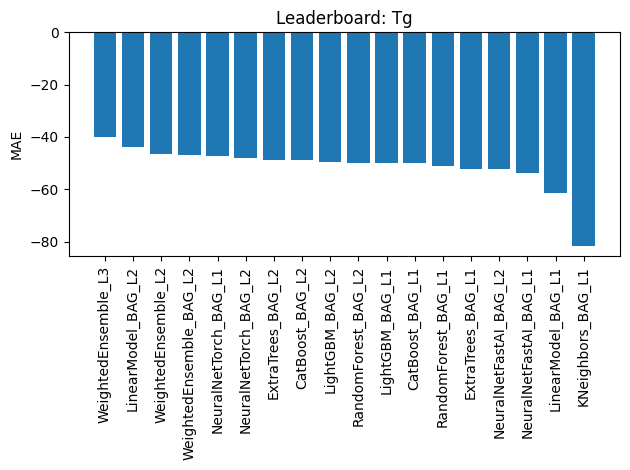

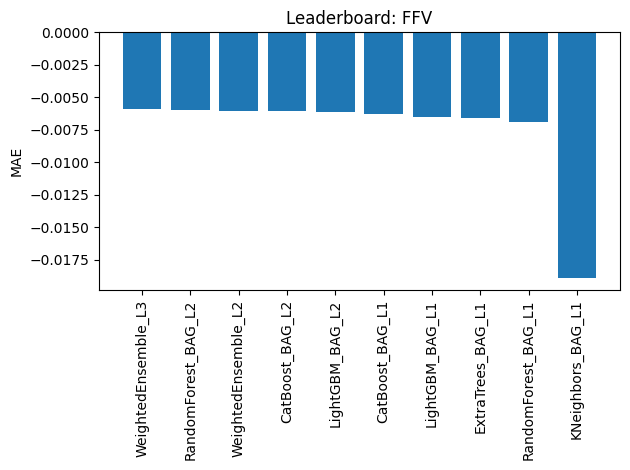

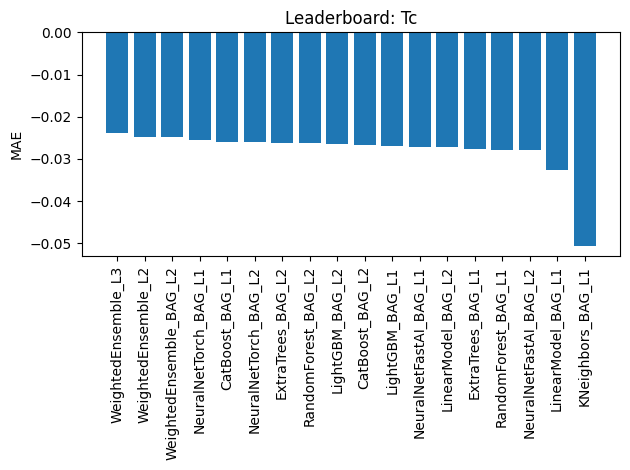

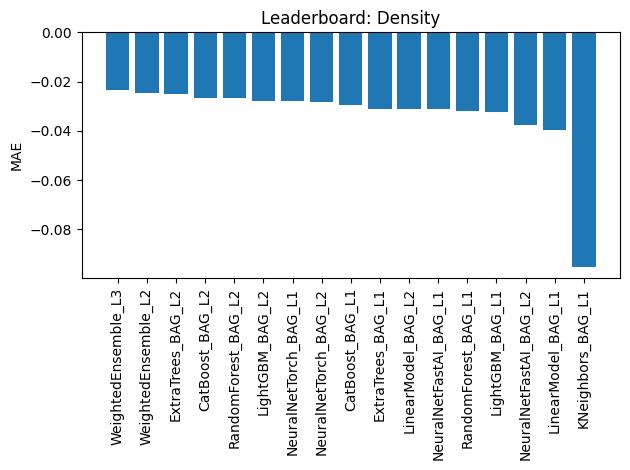

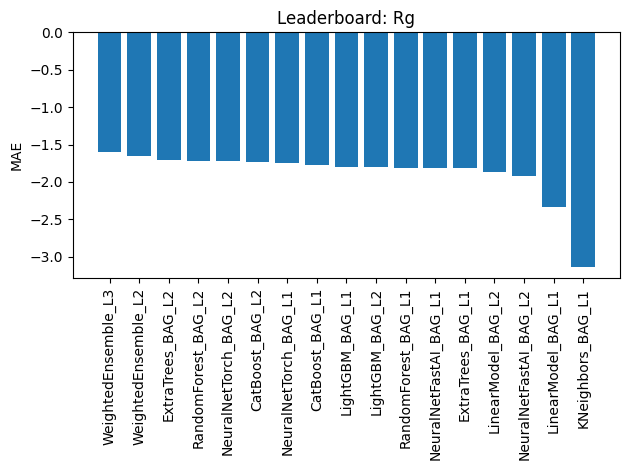

In [14]:
import matplotlib.pyplot as plt

for target, lb in leaderboards.items():
    plt.figure()
    plt.title(f"Leaderboard: {target}")
    plt.bar(lb['model'], lb['score_val'])
    plt.xticks(rotation=90)
    plt.ylabel("MAE")
    plt.tight_layout()
    plt.show()


In [15]:
# # Define all target properties
# targets = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

# # Store trained models and scalers
# trained_models = {}
# trained_scalers = {}
# cv_scores = []

# # Train each target - collect results for summary
# for target in targets:
#     print(f"Training {target}...")
#     models, scaler, features, cv_score = train_target_property_autogluon(train_features, train_df, target)
#     trained_models[target] = models
#     trained_scalers[target] = scaler
#     cv_scores.append(cv_score)
#     print()

# # Clean summary with average
# print("=" * 40)
# print(f"Trained: {len(targets)} targets × 5 CV folds = {len(targets) * 5} models")
# print(f"Average CV MAE across all targets: {np.mean(cv_scores):.4f}")

# Function to Predict using trained LGBM models for a given target
* Runs same RDKit feature generation on test SMILES data
* Uses the 5 trained models to predict a specific target
* Averages predictions from all 5 models for final result

In [16]:
def predict_target_property_autogluon(test_df, target_name, predictor):
    print(f"PREDICTING: {target_name}")
    
    if predictor is None:
        print(f"❌ No trained predictor available for {target_name}, returning zeros")
        return np.zeros(len(test_df))
    
    # Make sure test_df is processed to match training features
    descriptor_functions, feature_names = molecular_descriptors
    X_raw = smiles_to_features(test_df['SMILES'].values, descriptor_functions)
    X = pd.DataFrame(clean_features(X_raw))
    X.columns = feature_names 
    
    # AutoGluon works directly with DataFrames
    predictions = predictor.predict(X).values
    print(f"📊 Predictions range: {predictions.min():.4f} to {predictions.max():.4f}")
    
    return predictions


# Predict All Targets / Submit
* Predicts on test data
* Creates final submission CSV with all predictions

In [17]:
print(f"\nMAKING PREDICTIONS...")
all_predictions = {}
for target in targets:
    predictions = predict_target_property_autogluon(
        test_df, target, trained_models[target]
    )
    all_predictions[target] = predictions


# Create submission
submission = pd.DataFrame({'id': test_df['id']})
for target in targets:
    submission[target] = all_predictions[target]

submission.to_csv('submission.csv', index=False)

print(f"Predicted: {len(test_df)} test samples")
print(f"Saved: submission.csv")

print(f"\n👀 SUBMISSION PREVIEW:")
print(submission.head().to_string(index=False, float_format='%.4f'))


MAKING PREDICTIONS...
PREDICTING: Tg
Processing 3 SMILES... 3/3 ✅
🧹 Cleaned 37 missing values (5.7%)
📊 Predictions range: 63.9505 to 137.9667
PREDICTING: FFV
Processing 3 SMILES... 3/3 ✅
🧹 Cleaned 37 missing values (5.7%)
📊 Predictions range: 0.3510 to 0.3795
PREDICTING: Tc
Processing 3 SMILES... 3/3 ✅
🧹 Cleaned 37 missing values (5.7%)
📊 Predictions range: 0.2153 to 0.2742
PREDICTING: Density
Processing 3 SMILES... 3/3 ✅
🧹 Cleaned 37 missing values (5.7%)
📊 Predictions range: 1.0682 to 1.1646
PREDICTING: Rg
Processing 3 SMILES... 3/3 ✅
🧹 Cleaned 37 missing values (5.7%)
📊 Predictions range: 10.6258 to 12.4527
Predicted: 3 test samples
Saved: submission.csv

👀 SUBMISSION PREVIEW:
        id       Tg    FFV     Tc  Density      Rg
1109053969 109.0764 0.3744 0.2153   1.1646 12.4527
1422188626 137.9667 0.3795 0.2713   1.0682 12.0805
2032016830  63.9505 0.3510 0.2742   1.0979 10.6258
